# Imports

In [1]:
import os
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as layers

import gym
from gym import spaces
from PIL import Image
from collections import deque, namedtuple

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from environments import Snake
from methods import QNetwork, ReplayMemory
from agents import SnakeDQNAgent

# NN training

In [4]:
aa = SnakeDQNAgent(grid_size=[8, 8], model_name="grid8x8")

In [5]:
aa.set_parameters(max_episode_length=1000, replay_memory_size=50000, replay_start_size=10000,
                  discount_factor=1, final_eps=0.01, annealing_steps=500000)

In [ ]:
aa.train(gpu_id=0, batch_size=32, from_epoch=0)

Train info: 4419 -0.9 0.99125038000019
Train info: 9044 -0.888 0.9820928800003887
Train info: 13507 -0.88 0.9732561400005806
Train info: 18225 -0.864 0.9639145000007834
Train info: 22671 -0.864 0.9551114200009745
Train info: 27218 -0.888 0.9461083600011699
Train info: 31876 -0.878 0.9368855200013702
Train info: 36714 -0.882 0.9273062800015781
Train info: 41263 -0.872 0.9182992600017736
Train info: 45978 -0.884 0.9089635600019763
Train info: 50295 -0.888 0.9004159000021619
Train info: 54948 -0.886 0.8912029600023619
Train info: 59596 -0.872 0.8819999200025617
Train info: 64179 -0.874 0.8729255800027587
Train info: 69202 -0.88 0.8629800400029746
Train info: 74264 -0.842 0.8529572800031922
Train info: 78789 -0.896 0.8439977800033867
Train info: 83612 -0.868 0.834448240003594
Train info: 88519 -0.858 0.8247323800038049
Train info: 93264 -0.87 0.8153372800040088
Train info: 98388 -0.84 0.8051917600042291
Train info: 103445 -0.838 0.7951789000044465
Train info: 108940 -0.878 0.78429880000468

# Visualization

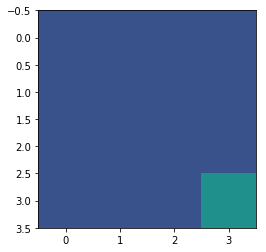

13

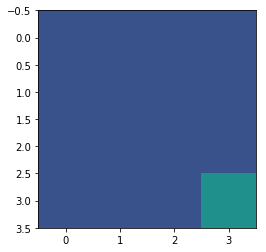

In [6]:
aa.play(gpu_id=2, max_episode_length=100, from_epoch=234)